# Лабораторная работа 4

Tensorflow 2.x

1) Подготовка данных

2) Использование Keras Model API

3) Использование Keras Sequential + Functional API

https://www.tensorflow.org/tutorials

Для выполнения лабораторной работы необходимо установить tensorflow версии 2.0 или выше .

Рекомендуется использовать возможности Colab'а по обучению моделей на GPU.



In [ ]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

# Подготовка данных
Загрузите набор данных из предыдущей лабораторной работы.

In [ ]:
def load_mnist(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    mnist = tf.keras.datasets.mnist.load_data()
    (X_train, y_train), (X_test, y_test) = mnist
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 28, 28, 1)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 28, 28, 1)
Validation labels shape:  (1000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


In [ ]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y

        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [ ]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 28, 28, 1) (64,)
1 (64, 28, 28, 1) (64,)
2 (64, 28, 28, 1) (64,)
3 (64, 28, 28, 1) (64,)
4 (64, 28, 28, 1) (64,)
5 (64, 28, 28, 1) (64,)
6 (64, 28, 28, 1) (64,)


In [ ]:
train_dset.X.shape

(49000, 28, 28, 1)

#  Keras Model Subclassing API


Для реализации собственной модели с помощью Keras Model Subclassing API необходимо выполнить следующие шаги:

1) Определить новый класс, который является наследником tf.keras.Model.

2) В методе __init__() определить все необходимые слои из модуля tf.keras.layer

3) Реализовать прямой проход в методе call() на основе слоев, объявленных в __init__()

Ниже приведен пример использования keras API для определения двухслойной полносвязной сети.

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras

In [ ]:
# Set up some global variables
USE_GPU = True  # Установка флага, указывающего, следует ли использовать GPU

# Проверяем значение флага USE_GPU
if USE_GPU:
    device = '/device:GPU:0'  # Устанавливаем устройство в GPU, если USE_GPU установлено в True
else:
    device = '/cpu:0'  # Устанавливаем устройство в CPU, если USE_GPU установлено в False

# Constant to control how often we print when training models
print_every = 100  # Константа, определяющая, как часто выводить информацию при обучении моделей


print('Using device: ', device)


Using device:  /device:GPU:0


In [ ]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super(TwoLayerFC, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0, seed=42)
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
                                   kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
                                   kernel_initializer=initializer)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    x = tf.zeros((64, input_size))
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_TwoLayerFC()

(64, 10)


Реализуйте трехслойную CNN для вашей задачи классификации.

Архитектура сети:
    
1. Сверточный слой (5 x 5 kernels, zero-padding = 'same')
2. Функция активации ReLU
3. Сверточный слой (3 x 3 kernels, zero-padding = 'same')
4. Функция активации ReLU
5. Полносвязный слой
6. Функция активации Softmax

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense

In [ ]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # Определение слоев для сверточной нейронной сети.
        ########################################################################
        self.conv1 = tf.keras.layers.Conv2D(channel_1, (5, 5), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(channel_2, (3, 3), padding='same', activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        ########################################################################
        # Прямой проход для сверточной нейронной сети.
        ########################################################################
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
def test_ThreeLayerConvNet():
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
        print(scores.shape)

test_ThreeLayerConvNet()

(64, 10)


Пример реализации процесса обучения:

In [ ]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.

    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for

    Returns: val_accuracy, a list containing val_accuracy.result()*100 after each iteration
    """
    with tf.device(device):


        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        model = model_init_fn()
        optimizer = optimizer_init_fn()

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

        t = 0
        val_accuracy_results = []  # Список для хранения val_accuracy после каждой итерации
        for epoch in range(num_epochs):

            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()

            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:

                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)

                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)

                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)

                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                        val_accuracy_results.append(val_accuracy.result()*100)  # Добавляем val_accuracy в список
                    t += 1
    # Преобразование тензоров в значения
    val_accuracy_results_numpy = [val.numpy() for val in val_accuracy_results]
    return val_accuracy_results_numpy


In [ ]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return TwoLayerFC(hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.061091423034668, Accuracy: 7.8125, Val Loss: 2.6353776454925537, Val Accuracy: 20.100000381469727
Iteration 100, Epoch 1, Loss: 0.6486901044845581, Accuracy: 80.30631256103516, Val Loss: 0.5465362071990967, Val Accuracy: 83.20000457763672
Iteration 200, Epoch 1, Loss: 0.5134938955307007, Accuracy: 84.65484619140625, Val Loss: 0.4487997889518738, Val Accuracy: 86.29999542236328
Iteration 300, Epoch 1, Loss: 0.45332732796669006, Accuracy: 86.5188980102539, Val Loss: 0.4038298428058624, Val Accuracy: 87.30000305175781
Iteration 400, Epoch 1, Loss: 0.40937238931655884, Accuracy: 87.87017059326172, Val Loss: 0.35987868905067444, Val Accuracy: 89.20000457763672
Iteration 500, Epoch 1, Loss: 0.3856959044933319, Accuracy: 88.60404205322266, Val Loss: 0.344133585691452, Val Accuracy: 90.20000457763672
Iteration 600, Epoch 1, Loss: 0.36190658807754517, Accuracy: 89.31208038330078, Val Loss: 0.33807018399238586, Val Accuracy: 90.80000305175781
Iteration 700, Epoch 1,

[20.1, 83.200005, 86.299995, 87.3, 89.200005, 90.200005, 90.8, 90.8]

Обучите трехслойную CNN. В tf.keras.optimizers.SGD укажите Nesterov momentum = 0.9 .

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD

Значение accuracy на валидационной выборке после 1 эпохи обучения должно быть > 50% .

In [ ]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 32, 16, 10

def model_init_fn():
    ############################################################################
    # Создание трехслойной CNN.
    ############################################################################
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    return model

def optimizer_init_fn():
    ############################################################################
    # Инициализация оптимизатора SGD с Nesterov momentum.
    ############################################################################
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.298362970352173, Accuracy: 7.8125, Val Loss: 2.2909932136535645, Val Accuracy: 10.699999809265137
Iteration 100, Epoch 1, Loss: 0.6980978846549988, Accuracy: 80.53836822509766, Val Loss: 0.48076167702674866, Val Accuracy: 84.30000305175781
Iteration 200, Epoch 1, Loss: 0.5049687623977661, Accuracy: 85.75870513916016, Val Loss: 0.345444917678833, Val Accuracy: 89.70000457763672
Iteration 300, Epoch 1, Loss: 0.404794842004776, Accuracy: 88.4966812133789, Val Loss: 0.20451979339122772, Val Accuracy: 93.0
Iteration 400, Epoch 1, Loss: 0.33888041973114014, Accuracy: 90.30548095703125, Val Loss: 0.19713424146175385, Val Accuracy: 93.4000015258789
Iteration 500, Epoch 1, Loss: 0.3000856339931488, Accuracy: 91.38909912109375, Val Loss: 0.17276550829410553, Val Accuracy: 94.0
Iteration 600, Epoch 1, Loss: 0.2695196270942688, Accuracy: 92.27849578857422, Val Loss: 0.19341063499450684, Val Accuracy: 93.19999694824219
Iteration 700, Epoch 1, Loss: 0.2462928742170334, 

[10.7, 84.3, 89.700005, 93.0, 93.4, 94.0, 93.2, 94.2]

# Использование Keras Sequential API для реализации последовательных моделей.

Пример для полносвязной сети:

In [ ]:
learning_rate = 1e-2

def model_init_fn():
    #изменил размер под свои данные
    input_shape = (28,28,1)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.904587745666504, Accuracy: 7.8125, Val Loss: 2.6004679203033447, Val Accuracy: 19.0
Iteration 100, Epoch 1, Loss: 0.6661937236785889, Accuracy: 79.95049285888672, Val Loss: 0.5377596020698547, Val Accuracy: 81.69999694824219
Iteration 200, Epoch 1, Loss: 0.5225178003311157, Accuracy: 84.42163848876953, Val Loss: 0.44929206371307373, Val Accuracy: 86.0
Iteration 300, Epoch 1, Loss: 0.45913681387901306, Accuracy: 86.22300720214844, Val Loss: 0.4148291349411011, Val Accuracy: 86.69999694824219
Iteration 400, Epoch 1, Loss: 0.41346296668052673, Accuracy: 87.67923736572266, Val Loss: 0.3665194809436798, Val Accuracy: 89.5
Iteration 500, Epoch 1, Loss: 0.3897799849510193, Accuracy: 88.43251037597656, Val Loss: 0.350651353597641, Val Accuracy: 89.9000015258789
Iteration 600, Epoch 1, Loss: 0.36594459414482117, Accuracy: 89.15349578857422, Val Loss: 0.3309897780418396, Val Accuracy: 90.30000305175781
Iteration 700, Epoch 1, Loss: 0.34794992208480835, Accuracy: 89.

[19.0, 81.7, 86.0, 86.7, 89.5, 89.9, 90.3, 90.7]

Альтернативный менее гибкий способ обучения:

In [ ]:
model = model_init_fn()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.2218 - sparse_categorical_accuracy: 0.9351


[0.22181575000286102, 0.9351000189781189]

Перепишите реализацию трехслойной CNN с помощью tf.keras.Sequential API . Обучите модель двумя способами.

In [ ]:
def model_init_fn():
    model = tf.keras.Sequential([
        # Первый сверточный слой
        tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)),
        # Первый пулинг слой
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        # Второй сверточный слой
        tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
        # Второй пулинг слой
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        # Разворачиваем данные перед подачей на полносвязный слой
        tf.keras.layers.Flatten(),
        # Полносвязный слой с relu активацией
        tf.keras.layers.Dense(1024, activation='relu'),
        # Выходной слой с softmax активацией
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

learning_rate = 5e-4

def optimizer_init_fn():
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.3262243270874023, Accuracy: 3.125, Val Loss: 2.1592679023742676, Val Accuracy: 27.700000762939453
Iteration 100, Epoch 1, Loss: 0.3918904960155487, Accuracy: 88.42821502685547, Val Loss: 0.2755052149295807, Val Accuracy: 90.69999694824219
Iteration 200, Epoch 1, Loss: 0.27461543679237366, Accuracy: 91.66667175292969, Val Loss: 0.3086024820804596, Val Accuracy: 89.70000457763672
Iteration 300, Epoch 1, Loss: 0.2162046730518341, Accuracy: 93.45930480957031, Val Loss: 0.10124920308589935, Val Accuracy: 96.5999984741211
Iteration 400, Epoch 1, Loss: 0.17914971709251404, Accuracy: 94.53709411621094, Val Loss: 0.11774175614118576, Val Accuracy: 95.80000305175781
Iteration 500, Epoch 1, Loss: 0.1585817039012909, Accuracy: 95.20646667480469, Val Loss: 0.09383785724639893, Val Accuracy: 97.0
Iteration 600, Epoch 1, Loss: 0.1431358903646469, Accuracy: 95.66607666015625, Val Loss: 0.11915887147188187, Val Accuracy: 96.80000305175781
Iteration 700, Epoch 1, Loss: 0.13

[27.7, 90.7, 89.700005, 96.6, 95.8, 97.0, 96.8, 96.8]

In [ ]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 9s 30ms/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9669


[0.11515253037214279, 0.9668999910354614]

# Использование Keras Functional API

Для реализации более сложных архитектур сети с несколькими входами/выходами, повторным использованием слоев, "остаточными" связями (residual connections) необходимо явно указать входные и выходные тензоры.

Ниже представлен пример для полносвязной сети.

In [ ]:
def two_layer_fc_functional(input_shape, hidden_size, num_classes):
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    inputs = tf.keras.Input(shape=input_shape)
    flattened_inputs = tf.keras.layers.Flatten()(inputs)
    fc1_output = tf.keras.layers.Dense(hidden_size, activation='relu',
                                 kernel_initializer=initializer)(flattened_inputs)
    scores = tf.keras.layers.Dense(num_classes, activation='softmax',
                             kernel_initializer=initializer)(fc1_output)

    # Instantiate the model given inputs and outputs.
    model = tf.keras.Model(inputs=inputs, outputs=scores)
    return model

def test_two_layer_fc_functional():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    input_shape = (50,)

    x = tf.zeros((64, input_size))
    model = two_layer_fc_functional(input_shape, hidden_size, num_classes)

    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_two_layer_fc_functional()

(64, 10)


In [ ]:
input_shape = (28, 28, 1)
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return two_layer_fc_functional(input_shape, hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.9366397857666016, Accuracy: 12.5, Val Loss: 2.527924060821533, Val Accuracy: 20.299999237060547
Iteration 100, Epoch 1, Loss: 0.6420687437057495, Accuracy: 80.21348571777344, Val Loss: 0.5606589913368225, Val Accuracy: 81.0
Iteration 200, Epoch 1, Loss: 0.509356677532196, Accuracy: 84.61598205566406, Val Loss: 0.45738887786865234, Val Accuracy: 85.0999984741211
Iteration 300, Epoch 1, Loss: 0.45254045724868774, Accuracy: 86.40469360351562, Val Loss: 0.41787296533584595, Val Accuracy: 86.69999694824219
Iteration 400, Epoch 1, Loss: 0.40941914916038513, Accuracy: 87.74937438964844, Val Loss: 0.3659650683403015, Val Accuracy: 89.30000305175781
Iteration 500, Epoch 1, Loss: 0.3858957290649414, Accuracy: 88.454345703125, Val Loss: 0.34306827187538147, Val Accuracy: 89.80000305175781
Iteration 600, Epoch 1, Loss: 0.36345019936561584, Accuracy: 89.13529205322266, Val Loss: 0.3309650719165802, Val Accuracy: 90.10000610351562
Iteration 700, Epoch 1, Loss: 0.3461658

[20.3, 81.0, 85.1, 86.7, 89.3, 89.8, 90.100006, 90.3]

Поэкспериментируйте с архитектурой сверточной сети. Для вашего набора данных вам необходимо получить как минимум 70% accuracy на валидационной выборке за 10 эпох обучения. Опишите все эксперименты и сделайте выводы (без выполнения данного пункта работы приниматься не будут).

Эспериментируйте с архитектурой, гиперпараметрами, функцией потерь, регуляризацией, методом оптимизации.  

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization#methods https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout#methods

CustomConvNet_B_D имеет более глубокую архитектуру с четырьмя сверточными слоями, в то время как остальные две модели содержат только два сверточных слоя.
CustomConvNet_B_D использует функцию активации ReLU, в то время как CustomConvNet_Sig применяет сигмоидальную функцию активации.
CustomConvNet не использует сигмоидальную функцию активации и имеет слои макспулинга после сверточных слоев

In [ ]:
class CustomConvNet_B_D(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet_B_D, self).__init__()
        channel_1, channel_2, channel_3, channel_4, num_classes = 28, 14, 14, 14, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)

        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.dp1 = tf.keras.layers.Dropout(rate=dp_rate)

        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.dp2 = tf.keras.layers.Dropout(rate=dp_rate)

        self.conv3 = tf.keras.layers.Conv2D(channel_3, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.ReLU()
        self.dp3 = tf.keras.layers.Dropout(rate=dp_rate)

        self.conv4 = tf.keras.layers.Conv2D(channel_4, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.relu4 = tf.keras.layers.ReLU()
        self.dp4 = tf.keras.layers.Dropout(rate=dp_rate)

        self.fl = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(num_classes * 2,
                                  activation='relu',
                                  kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  kernel_initializer=initializer)

    def call(self, input_tensor, training=False):
        x = input_tensor
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dp1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dp2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dp3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dp4(x)

        x = self.fl(x)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [ ]:
class CustomConvNet(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet, self).__init__()

        channel_1, channel_2, num_classes = 32, 64, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)

        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2)

        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3,3], [1,1], padding='same',
                                  kernel_initializer=initializer)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=[2,2], strides=2)

        self.fl = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  kernel_initializer=initializer)


    def call(self, input_tensor, training=False):
        x = input_tensor

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.fl(x)
        x = self.fc(x)

        return x

In [ ]:
class CustomConvNet_Sig(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet_Sig, self).__init__()

        channel_1, channel_2, num_classes = 28, 14, 10
        dp_rate = 0.2
        initializer = tf.initializers.VarianceScaling(scale=2.0)

        self.conv1 = tf.keras.layers.Conv2D(channel_1, [3, 3], [1, 1], padding='same',
                                            kernel_initializer=initializer)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.ReLU()
        self.max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2])

        self.conv2 = tf.keras.layers.Conv2D(channel_2, [3, 3], [1, 1], padding='same',
                                            kernel_initializer=initializer)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.ReLU()
        self.max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2])

        self.fl = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(num_classes,
                                        activation='softmax',
                                        kernel_initializer=initializer)

    def call(self, input_tensor, training=False):

        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = tf.keras.activations.sigmoid(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.keras.activations.sigmoid(x)
        x = self.max_pool2(x)

        x = self.fl(x)
        x = self.fc(x)

        return x

In [ ]:
print_every = 500
num_epochs = 10
# Задаем параметры эксперимента
configs = [
    {
        "model": "CustomConvNet_B_D",
        "optimizer": "Adam",
        "learning_rate": 1e-3
    },
    {
        "model": "CustomConvNet_B_D",
        "optimizer": "Adam",
        "learning_rate": 1e-4
    },
    {
        "model": "CustomConvNet_B_D",
        "optimizer": "SGD",
        "learning_rate": 1e-3
    },
    {
        "model": "CustomConvNet",
        "optimizer": "Adam",
        "learning_rate": 1e-3,
    },
    {
        "model": "CustomConvNet",
        "optimizer": "Adam",
        "learning_rate": 1e-4,
    },
    {
        "model": "CustomConvNet",
        "optimizer": "SGD",
        "learning_rate": 1e-3,
    },
    {
        "model": "CustomConvNet_Sig",
        "optimizer": "Adam",
        "learning_rate": 1e-3,
    },
    {
        "model": "CustomConvNet_Sig",
        "optimizer": "Adam",
        "learning_rate": 1e-4,
    },
    {
        "model": "CustomConvNet_Sig",
        "optimizer": "SGD",
        "learning_rate": 1e-3,
    }
]

# Определяем функции для создания модели и оптимизатора
def model_init_fn(model_name):
    if model_name == "CustomConvNet_B_D":
        return CustomConvNet_B_D()
    elif model_name == "CustomConvNet":
        return CustomConvNet()
    elif model_name == "CustomConvNet_Sig":
        return CustomConvNet_Sig()

def optimizer_init_fn(optimizer_name, learning_rate):
    if optimizer_name == "Adam":
        return tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == "SGD":
        return tf.keras.optimizers.SGD(learning_rate)

# Функция для обучения модели
def train_model(model_init_fn, optimizer_init_fn, num_epochs, print_every):
    model = model_init_fn()
    optimizer = optimizer_init_fn()
    history = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)
    print(history)
    return history



Experiment with model: CustomConvNet_B_D | optimizer: Adam | learning rate: 0.001
Iteration 0, Epoch 1, Loss: 2.856781482696533, Accuracy: 9.375, Val Loss: 2.6928203105926514, Val Accuracy: 12.399999618530273
Iteration 500, Epoch 1, Loss: 0.4647004306316376, Accuracy: 85.83457946777344, Val Loss: 0.21077963709831238, Val Accuracy: 93.5999984741211
Iteration 1000, Epoch 2, Loss: 0.15165944397449493, Accuracy: 95.50531768798828, Val Loss: 0.1438649445772171, Val Accuracy: 95.0999984741211
Iteration 1500, Epoch 2, Loss: 0.1283145695924759, Accuracy: 96.16071319580078, Val Loss: 0.15588515996932983, Val Accuracy: 94.70000457763672
Iteration 2000, Epoch 3, Loss: 0.0961507111787796, Accuracy: 97.1715087890625, Val Loss: 0.12440524995326996, Val Accuracy: 95.5
Iteration 2500, Epoch 4, Loss: 0.08763812482357025, Accuracy: 97.2752456665039, Val Loss: 0.12928402423858643, Val Accuracy: 96.0
Iteration 3000, Epoch 4, Loss: 0.07953690737485886, Accuracy: 97.53955841064453, Val Loss: 0.129541262984

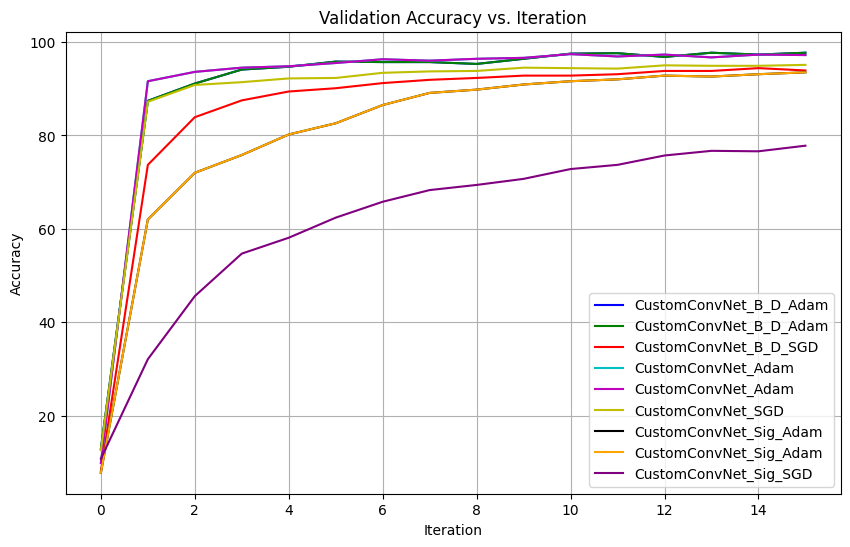

In [ ]:
# Создаем список цветов для каждого эксперимента
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

# Создаем пустой словарь для сохранения истории точности каждого эксперимента
accuracy_history = {}

# Запускаем эксперименты
for i, config in enumerate(configs):
    print("\nExperiment with model:", config["model"], "| optimizer:", config["optimizer"], "| learning rate:", config["learning_rate"])
    history = train_model(lambda: model_init_fn(config["model"]), lambda: optimizer_init_fn(config["optimizer"], config["learning_rate"]), num_epochs, print_every)
    accuracy_history[config["model"] + "_" + config["optimizer"]] = history

# Создаем график
plt.figure(figsize=(10, 6))

# Для каждого эксперимента строим график точности на валидационной выборке
for i, config in enumerate(configs):
    model_name = config["model"]
    optimizer_name = config["optimizer"]
    history = accuracy_history[model_name + "_" + optimizer_name]
    plt.plot(range(len(history)), history, label=model_name + "_" + optimizer_name, color=colors[i])

# Настройки графика
plt.title('Validation Accuracy vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Отображаем график
plt.show()

Опишите все эксперименты, результаты. Сделайте выводы.


В общем, можно отметить, что точность моделей значительно улучшается с увеличением числа эпох обучения, что является типичным поведением. Кроме того, значения learning rate и выбор оптимизатора также оказывают влияние на скорость обучения и достигаемую точность.

Например, модель CustomConvNet_B_D с оптимизатором Adam и learning rate 0.001 достигает точности около 97.5% после 10 эпох обучения, в то время как та же модель с learning rate 0.0001 достигает примерно 97.2% точности. Это показывает, что learning rate 0.001 дает лучший результат для данной модели и оптимизатора.

С другой стороны, модель CustomConvNet с оптимизатором SGD и learning rate 0.001 показывает точность около 95.1% после 10 эпох, в то время как точность CustomConvNet с оптимизатором Adam и тем же learning rate достигает около 97.4% после той же продолжительности обучения.